# Ponderación de verosimilitud

El algoritmo de ponderación de verosimilitud es un método de muestreo por importancia, métodos que se enfocan en usar una distribución particular $Q$ para obtener la inferencia de la distribución objetivo $P$. Presentamos una aplicación de la ponderación de verosimilitud para la red bayesiana correspondiente al problema de Monty Hall. Usamos este método para estimar la probabilidad de elegir entre la puerta previamente dada (la puerta del invitado) y la otra puerta con base en la evidencia de las elecciones del invitado y Monty.

In [1]:
import numpy as np
from bayesian_monty import MontyNetwork

#Guarda la estructura de red Bayesiana
bn = MontyNetwork()

### Muestreo pesado

La ponderación de verosimilitud se basa en una función de muestreo pesado. Esta función toma valores determinados de la evidencia (que en nuestro caso corresponden a las elecciones del invitado y del presentador, Monty), y muestrea los valores que no son evidencia (en este caso, el premio) condicionados a sus padres en un orden topológico. Este orden topológico es aquí $X_0, X_1, X_2$, pues $X_0$ y $X_1$ no están condicionados a ninguna otra variable (también se podría tomar el orden $X_1, X_0, X_2$), mientras que $X_2$ se explora al final, pues está condicionada a las variables anteriores.

El muestreo pesado devuelve el resultado de la muestra, pero también regresa un peso, que es una probabilidad determinada como:

$$w(x) = \prod_{i=1}^l p\big(x_i|\pi(X_i) \big)$$

Por lo tanto, no sólo se obtiene la muestra, sino un peso que representa la probabilidad de esta muestra.    

In [2]:
def weighted_sample(bn, guest, monty):
    """Realiza un muestreo aleatorio con peso, según evidencia"""
    #Inicializa peso y muestra
    w = 1
    x = 0
    for Xi in [bn.X0, bn.X1, bn.X2]:
        #Revisa las variables
        #Si no es evidencia, genera una muestra
        if Xi.name == 'prizeDoor':
            x = np.random.choice([0,1,2], p= Xi.cpt)
        #Si es evidencia, toma el valor con peso
        elif Xi.name == 'guestDoor':
            w = w*Xi.cpt[guest]
        else:
            w = w*Xi.cpt[x,monty,guest]
            
    return x,w

Podemos ver un ejemplo de lo que devuelve la función, el primer elemento es la muestra: la elección posible de una de las puertas; el segundo elemento es el peso $w(x)$.

In [3]:
weighted_sample(bn, guest=1, monty=2)

(0, 0.3333333333333333)

## Algoritmo de ponderación de la verosimilitud

Finalmente, para realizar la estimación de la probabilidad de la consulta (que en este caso es la probabilidad de que el premio esté en alguna de las puertas dada las elecciones anteriores), el algoritmo tomará un vector de valores $W$ y cada vez que haga una muestra no sumará 1 (como lo hacia el muestreo por rechazo), si no el peso de esta muestra. Esto es:

$$W(x_i) = \sum_{j=1}^N w(x)_j$$

Donde $N$ es el número de muestras que se desean realizar. De nuevo, entre mayor sea $N$ más nos acercaremos a la probabilidad real, por la ley de los grandes números. Finalmente, los valores se normalizan para obtener probabilidades.

In [4]:
def likelihood_weighting(bn, guest, monty, N=100):
    """Inferencia por ponderación de verosimilitud"""
    #Inicializa los valores
    W = np.zeros(3)
    for j in range(N):
        #Aplica muestreo ponderado
        x,w = weighted_sample(bn, guest,monty)
        #Actualiza los valores
        W[x] = W[x] + w
        
    return W/W.sum()

Podemos observar que al correr el método para $N=1000$ muestras podemos obtener valores bastante cercanos a la probabilidad que esperamos obtener:

In [5]:
#Realzia la inferencia
pX1 = likelihood_weighting(bn, guest=1,monty=2, N=1000)

#Imprime los resiltados
for i in range(3):
    print('p(X1={}|X0=1, X2=2)={}'.format(i, np.round(pX1[i],2)))

p(X1=0|X0=1, X2=2)=0.65
p(X1=1|X0=1, X2=2)=0.35
p(X1=2|X0=1, X2=2)=0.0


### Convergencia de la inferencia

Finalmente, podemos ver como convergen los valores de las probabilidades según el número de muestras que se han realizado.

In [6]:
p0, p1, p2 = [], [], []
W = np.zeros(3)
for j in range(1,1000):
    x,w = weighted_sample(bn, 1,2)
    W[x] = W[x] + w
    prob = W/W.sum()
    p0.append(prob[0])
    p1.append(prob[1])
    p2.append(prob[2])

Como se puede observar, entre más crece el número de meustras más se acercan las probabilidades estimadas por ponderación de la verosimilitud a las probabilidades reales, estabilizándose cerca de los valores de $\frac{2}{3}$ y $\frac{1}{3}$. Puede, además, observarse, que la convergencia parece estabilizarse más rápido que con el muestreo por rechazo.

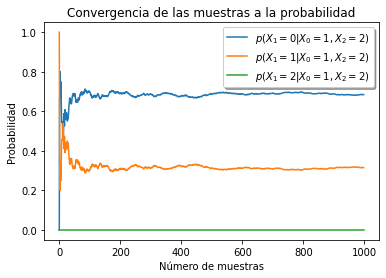

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(p0, label='$p(X_1=0|X_0=1,X_2=2)$')
ax.plot(p1, label='$p(X_1=1|X_0=1,X_2=2)$')
ax.plot(p2, label='$p(X_1=2|X_0=1,X_2=2)$')
legend = ax.legend(loc='upper right', shadow=True)
plt.title('Convergencia de las muestras a la probabilidad')
plt.xlabel('Número de muestras')
plt.ylabel('Probabilidad')
plt.show()